In [1]:
import pyreadr
import numpy as onp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.stats import linregress

import sys
import os
# sys.path.append("../../../models") # lab server
sys.path.append("../../../contrastive-regression/models/") # lab server
# from linear_cr import LinearCR
from linear_cr_new import LinearContrastiveRegression

In [2]:
def return_indices_of_a(a, b):
  b_set = set(b)
  return [i for i, v in enumerate(a) if v in b_set]

In [3]:
ct = 'L2or3'
df = pyreadr.read_r('../pb/'+ ct + '.rds')[None]
hvg = pyreadr.read_r('../hvg1k/'+ ct +'.rds')[None]
input1 = df.index.values.tolist()
input2 = hvg[None].to_list()
match_id = return_indices_of_a(input1,input2)
# print(len(match_id))
df = df.iloc[match_id]
print(df.shape)

(1000, 41)


In [4]:
score_type = 'scoreA'
output_dir = './' + score_type + '/'
if not os.path.exists(output_dir):
   os.makedirs(output_dir)

score = pyreadr.read_r('../'+ score_type + '_pfc.rds')[None]
print(score.shape)

(20, 5)


In [5]:
X = df[score['sample'][score['diagnosis']=='ASD'].to_list()].to_numpy().T
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(10, 1000)


In [6]:
# A = df[score['sample'][score['diagnosis']=='ASD'].to_list()]
# print(list(A) == score['sample'][score['diagnosis']=='ASD'].to_list())
Y = df[score['sample'][score['diagnosis']=='Control'].to_list()].to_numpy().T
print(type(Y))
print(Y.shape)

<class 'numpy.ndarray'>
(10, 1000)


In [7]:
R = score['zscore'][score['diagnosis']=='ASD']
R = onp.atleast_2d(R).T
#print(R)

In [8]:
# Instantiate model
model = LinearContrastiveRegression()

# Fit model
d = 8 # dimension reduction
model.fit(X, Y, R, d, seed = 100)

# Make predictions on training data
preds = model.predict(X)

Step: 0               Log marginal lik.: -1972.26
Step: 200             Log marginal lik.: 20898.42
Step: 400             Log marginal lik.: 40638.84
Step: 600             Log marginal lik.: 58978.41
Step: 800             Log marginal lik.: 70956.46
Step: 1000            Log marginal lik.: 73196.12
Step: 1200            Log marginal lik.: 73151.83
Step: 1400            Log marginal lik.: 73117.52
Step: 1600            Log marginal lik.: 73237.05
Step: 1800            Log marginal lik.: 73229.39
Step: 2000            Log marginal lik.: 73135.45
Step: 2200            Log marginal lik.: 73206.2
Step: 2400            Log marginal lik.: 73240.05
Step: 2600            Log marginal lik.: 73176.23
Step: 2800            Log marginal lik.: 73131.84
Step: 3000            Log marginal lik.: 73099.23
Step: 3200            Log marginal lik.: 73178.19
Step: 3400            Log marginal lik.: 73188.22
Step: 3600            Log marginal lik.: 73172.11
Step: 3800            Log marginal lik.: 73141.59
S

In [9]:
_, _, r2_contrastivereg, _, _ = linregress(R.squeeze(), preds)
print(r2_contrastivereg)

0.8942021004278445


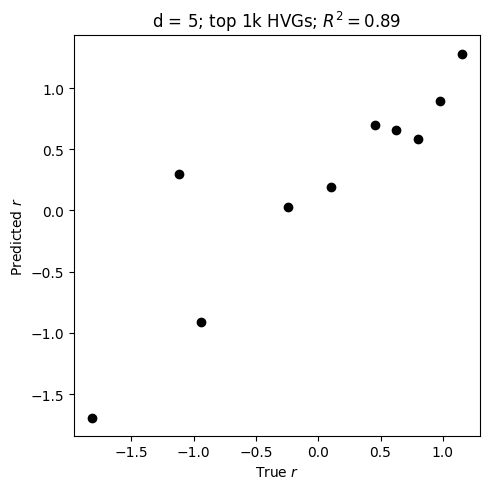

In [10]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.scatter(R, preds, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title(r"d = 5; top 1k HVGs; $R^2 = " + str(round(r2_contrastivereg, 2)) + "$")

plt.tight_layout()
plt.show()

In [11]:
# check latent factor t
latent_t = onp.asarray(model.t)
asd_sample = score['sample'][score['diagnosis']=='ASD'].to_list()
dims = ["Dim%d" % i for i in range(1,9)]

In [12]:
loading_w = pd.DataFrame(model.W, columns = df.index.to_list(), index = dims,dtype = "float")
pyreadr.write_rds(output_dir + 'seed100_W.rds', loading_w, compress="gzip")
print(loading_w.head())

      RP5-857K21.4  MTND1P23  MTND2P28  RP5-857K21.6  MTATP6P1     ACAP3  \
Dim1     -0.055902  0.019793 -0.061925     -0.029359  0.049779  0.035803   
Dim2      0.010454 -0.113961  0.102209     -0.142254  0.090259  0.115152   
Dim3     -0.005811  0.125214  0.139444      0.193749  0.036121  0.025308   
Dim4      0.099822 -0.079015 -0.048944     -0.135144  0.343136  0.082071   
Dim5      0.021538 -0.160117 -0.033225     -0.222382 -0.322725 -0.049549   

         GABRD      CHD5      ENO1    CLSTN1  ...  MAPK8IP2   TEKT4P2  \
Dim1  0.032869  0.024814  0.006120 -0.167795  ...  0.036557 -0.033532   
Dim2  0.103178  0.060848  0.044529  0.301663  ...  0.023604 -0.018260   
Dim3  0.060264  0.070129  0.067586  0.316026  ...  0.044337 -0.017671   
Dim4  0.066912  0.114065  0.035909  0.210717  ...  0.043732  0.058672   
Dim5 -0.133786 -0.266627 -0.117917 -0.425755  ... -0.130372  0.042770   

      bP-21201H5.1  ANKRD20A11P  MIR99AHG     ATP5J       APP      SOD1  \
Dim1     -0.062136    -0.0342

In [13]:
latent_t = pd.DataFrame(model.t, columns = dims, index = asd_sample, dtype="float")
pyreadr.write_rds(output_dir + 'seed100_t.rds', latent_t, compress="gzip")
print(latent_t.head())

              Dim1      Dim2      Dim3      Dim4      Dim5      Dim6  \
5144_PFC -0.722753  0.365775 -0.599536 -0.444759  0.095994  0.662477   
5278_PFC  0.013467 -0.065277  0.696176  0.095579  0.560865  0.015380   
5294_BA9 -0.201258  0.118389 -0.335411 -0.233259 -0.055289 -0.097901   
5403_PFC  0.039881  0.303204  0.067737  1.069785  0.211000  0.494211   
5419_PFC -0.472928  0.290897  0.700969  0.314448  0.297527 -0.445675   

              Dim7      Dim8  
5144_PFC  0.442501 -0.173982  
5278_PFC  0.385612 -0.470239  
5294_BA9  0.028244  0.034541  
5403_PFC -0.047593 -0.283951  
5419_PFC  0.840847  0.330221  


In [14]:
pyreadr.write_rds(output_dir + 'seed100_beta.rds', pd.DataFrame(data=model.beta), compress="gzip")

In [15]:
auxiliary_s = pd.DataFrame(model.S, columns = df.index.to_list(), index = dims, dtype="float")
print(auxiliary_s.head)
pyreadr.write_rds(output_dir + 'seed100_S.rds', auxiliary_s, compress="gzip")

<bound method NDFrame.head of       RP5-857K21.4  MTND1P23  MTND2P28  RP5-857K21.6  MTATP6P1     ACAP3  \
Dim1     -0.033026 -0.066598 -0.004835     -0.036625 -0.206754 -0.054018   
Dim2     -0.004842  0.165433  0.000030      0.225628  0.126666 -0.078264   
Dim3      0.067847 -0.062399  0.004624     -0.116434  0.211828  0.119569   
Dim4     -0.042475 -0.058787 -0.000672     -0.090863 -0.123018 -0.134006   
Dim5     -0.062191  0.080563 -0.003585      0.112391 -0.159848 -0.097980   
Dim6     -0.006779 -0.047135 -0.005311     -0.072855 -0.064903  0.011898   
Dim7      0.024863 -0.202478  0.002246     -0.256641  0.025322  0.016714   
Dim8      0.062772  0.133040  0.009460      0.186684  0.198858  0.040894   

         GABRD      CHD5      ENO1    CLSTN1  ...  MAPK8IP2   TEKT4P2  \
Dim1  0.031608 -0.065026  0.036604  0.148324  ... -0.006672  0.050729   
Dim2 -0.032692 -0.078261 -0.001341 -0.026490  ... -0.014929  0.017387   
Dim3  0.079752  0.172079  0.062652  0.210773  ...  0.050538  0.033

In [16]:
## sort by absolute value of beta
beta = onp.array(model.beta.T.flatten())
print(beta)
indices = onp.argsort(abs(beta))
max_abs_beta_index = indices[-1] # start from 0
target_dim = 'Dim' + str(max_abs_beta_index + 1)
print('Dimension with largest absolute value of beta: ' + target_dim)

[ 0.9662519   1.6591302  -1.4054949   0.68466645  1.209081   -0.4314881
  0.5733102  -0.30731687]
Dimension with largest absolute value of beta: Dim2


In [17]:
## sort gene (w)
w_d = loading_w.loc[[target_dim]].T
w_d['gene'] = w_d.index.values.tolist()
sorted_w_d = w_d.sort_values(by=target_dim, ascending=False)
sorted_w_d['rank'] = list(range(1,w_d.shape[0]+1))
sorted_w_d.to_csv(output_dir + 'seed100_gene_rank_max_abs_beta.csv', index = False)

sorted_w_d

,Dim2,gene,rank
MALAT1,2.155225,MALAT1,1
PCDH9,1.346627,PCDH9,2
PTPRD,1.323128,PTPRD,3
RASGEF1B,1.280001,RASGEF1B,4
CADM2,1.208188,CADM2,5
...,...,...,...
RP5-857K21.6,-0.142254,RP5-857K21.6,996
BAIAP2L2,-0.175693,BAIAP2L2,997
HSPB1,-0.193172,HSPB1,998
RP11-750B16.1,-0.202211,RP11-750B16.1,999
